In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from causalimpact import CausalImpact
import promotional_helpers as promies
from statsmodels.tsa.seasonal import STL

#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

# inliners
fcn_compare = lambda a,b: abs(a-b)/max(a,b)
fcn_compare_snap_vs_regular = lambda snap,reg: snap/reg
mapper_family_to_category = fhelp.cfav_get_map_dept_to_cat()

dataFolder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')

In [2]:
store_name = 'Pichincha_49_A_11'
dept_id = 'PRODUCE'
store_alias = f'''st_{store_name.split('_')[1]}'''

In [3]:
'PRODUCE_1489895-PRODUCE_1473401-0'

'PRODUCE_1489895-PRODUCE_1473401-0'

In [4]:
# Read departement sales for the current store
category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, category_id, dept_id, 'store_sales')
filename = os.path.join(foldername, f'{store_name}.pickle')
df_store = fhelp.readPickleFile(filename)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

df_store.head(2)

,date,weekdays,sales-PRODUCE_1149069-Pichincha_49_A_11,promotion_flag-PRODUCE_1149069-Pichincha_49_A_11,sales-PRODUCE_1473393-Pichincha_49_A_11,promotion_flag-PRODUCE_1473393-Pichincha_49_A_11,sales-PRODUCE_1473394-Pichincha_49_A_11,promotion_flag-PRODUCE_1473394-Pichincha_49_A_11,sales-PRODUCE_1473396-Pichincha_49_A_11,promotion_flag-PRODUCE_1473396-Pichincha_49_A_11,...,promotion_flag-PRODUCE_2037487-Pichincha_49_A_11,sales-PRODUCE_2040637-Pichincha_49_A_11,promotion_flag-PRODUCE_2040637-Pichincha_49_A_11,sales-PRODUCE_2042210-Pichincha_49_A_11,promotion_flag-PRODUCE_2042210-Pichincha_49_A_11,sales-PRODUCE_2049081-Pichincha_49_A_11,promotion_flag-PRODUCE_2049081-Pichincha_49_A_11,sales-PRODUCE_2111870-Pichincha_49_A_11,promotion_flag-PRODUCE_2111870-Pichincha_49_A_11,total_units
0,2017-01-01,Sunday,0.0,False,0.000,False,0.000,False,0.000,False,...,False,0.0,False,0.0,False,0.0,False,0.0,False,0.000
1,2017-01-02,Monday,41.0,False,131.902,False,89.291,False,23.551,False,...,False,26.0,False,26.0,False,0.0,False,0.0,False,13295.331


In [5]:
sku_id_A = 'PRODUCE_1489895'
sku_id_B = 'PRODUCE_1473401'

### Read the causal analysis results

In [6]:
folderCausalImpactResults = os.path.join(os.path.expanduser(dataFolder), 'CausalImpactResults', category_id, dept_id)
filenameCI = os.path.join(folderCausalImpactResults, f'{store_name}.pickle')
df_CI_analysis = fhelp.readPickleFile(filenameCI)

In [7]:
idx_cannibal = df_CI_analysis.cannibal.str.contains(sku_id_A)
idx_victim   = df_CI_analysis.victim.str.contains(sku_id_B)
idx_current_case = idx_cannibal & idx_victim

df_CI = df_CI_analysis[idx_current_case].reset_index().copy()
df_CI.head()
df_CI.iloc[0]

index                                                  2
cannibal                                 PRODUCE_1489895
victim                                   PRODUCE_1473401
slot_number                                            0
idx_regular_days                              [172, 177]
idx_promo_days                                [178, 192]
total_overlapping_days_regular                         6
regular_to_promo_gap                                   0
total_overlapping_days_promo                          15
competing_promo_days                                   3
sku_B_regular_avg_sales                          31.2393
sku_B_avg_sales_during_promo_sku_A                14.764
diff_in_units_from_reg_to_promo                  16.4753
diff_in_units_from_promo_to_pos_promo           -6.84886
ratio_change                                    0.527391
avg_actual                                        14.764
avg_predicted                                    31.2409
avg_abs_effect                 

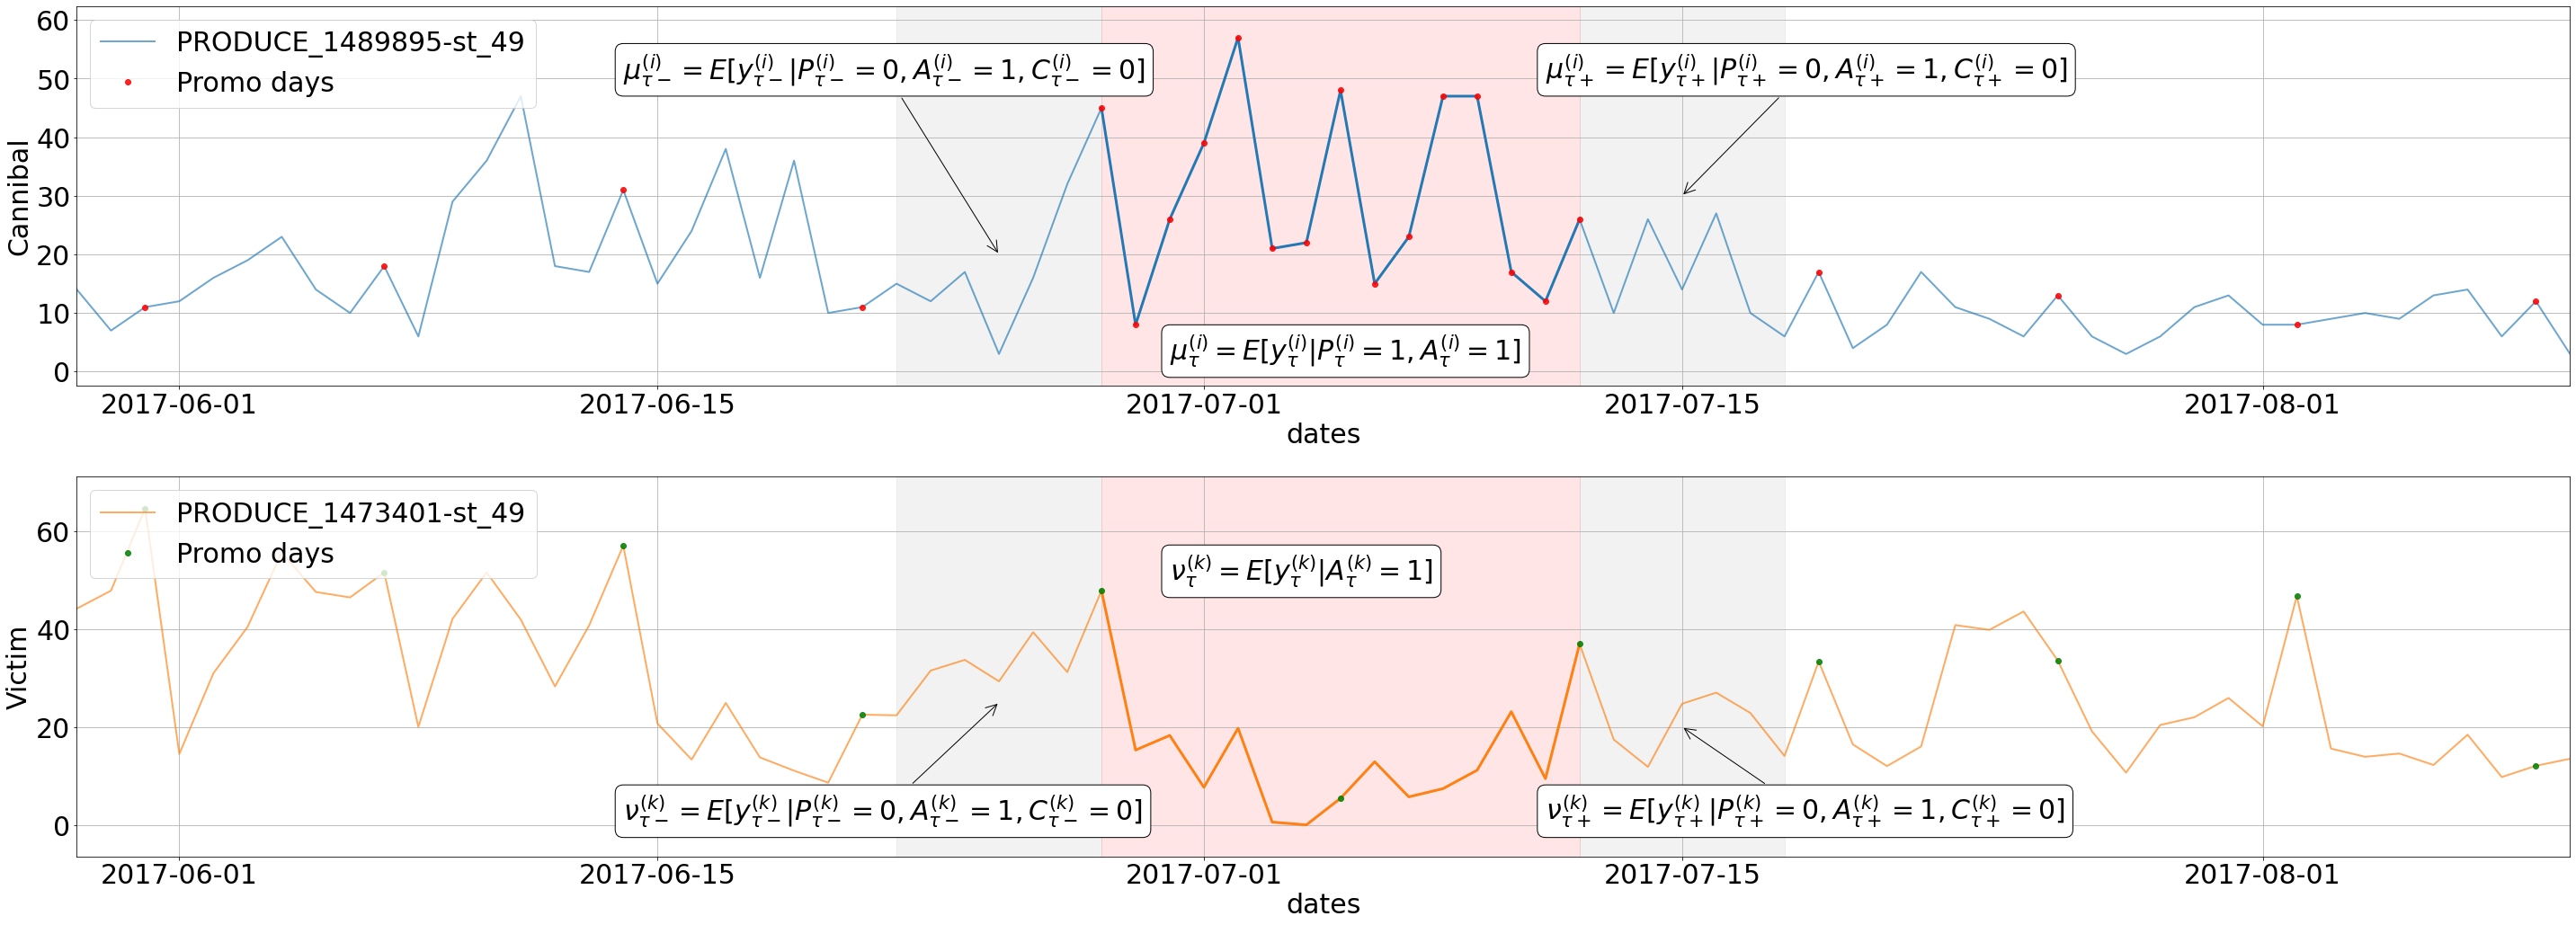

In [10]:
save_figure = True

# Plot one store
fig, ax = plt.subplots(2,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))


plt.rcParams.update({'font.size': 30})

total_days = df_store.shape[0]
num_days = np.arange(total_days)

# get the taxonomy
sku_A = df_store.filter(regex=f'sales-{sku_id_A}').columns[0]
category_id, dept_id, _, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)

start_period = df_CI.idx_promo_days[0][0]
end_period = df_CI.idx_promo_days[0][1]

xaxis_offset = 30
start_plot = start_period - xaxis_offset
end_plot = end_period + xaxis_offset

sku_B_reg = df_CI['sku_B_regular_avg_sales'][0]
sku_B_cannibalised = df_CI['sku_B_avg_sales_during_promo_sku_A'][0]
sku_B_predicted = df_CI['avg_predicted'][0]

slot_number = df_CI['slot_number'][0]

x_axis = df_store.date

idx_store = 0
idx_axis = 0

sales_sku_A = df_store[f'sales-{sku_id_A}-{store_name}']
ax[0].plot(x_axis[start_plot:end_plot], sales_sku_A[start_plot:end_plot], label=f'{sku_id_A}-{store_alias}',
        color=def_colours[idx_store], linewidth=2, alpha=0.65)


sales_sku_B = df_store[f'sales-{sku_id_B}-{store_name}']
ax[1].plot(x_axis[start_plot:end_plot], sales_sku_B[start_plot:end_plot], label=f'{sku_id_B}-{store_alias}',
        color=def_colours[idx_store+1], linewidth=2, alpha=0.65)

ax[0].plot(x_axis.iloc[start_period:end_period+1], sales_sku_A.iloc[start_period:end_period+1],
        color=def_colours[idx_store], linewidth=3, alpha=0.95)

ax[1].plot(x_axis.iloc[start_period:end_period+1], sales_sku_B.iloc[start_period:end_period+1],
        color=def_colours[idx_store+1], linewidth=3, alpha=0.95)

ax[0].axvspan(x_axis.iloc[start_period], x_axis.iloc[end_period], alpha=0.1, color='red')
ax[1].axvspan(x_axis.iloc[start_period], x_axis.iloc[end_period], alpha=0.1, color='red')

# Work out promo A days
promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
mask_sku_A = np.zeros(total_days, dtype=bool)
mask_sku_A[start_plot:end_plot+1]=True

masked_promo_A = promo_sku_A & mask_sku_A
ax[0].plot(x_axis[masked_promo_A], sales_sku_A[masked_promo_A], 'o', label=f'Promo days', 
            color='r', linewidth=2.5, alpha=0.85)


promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']
mask_sku_B = np.zeros(total_days, dtype=bool)
mask_sku_B[start_plot:end_plot+1]=True

masked_promo_B = promo_sku_B & mask_sku_B
ax[1].plot(x_axis[masked_promo_B], sales_sku_B[masked_promo_B], 'o', label=f'Promo days', 
            color='g', linewidth=2.5, alpha=0.85)


# Add regular days
start_period_regular = df_CI.idx_regular_days[0][0]
end_period_regular = df_CI.idx_regular_days[0][1]+1

ax[0].axvspan(x_axis.iloc[start_period_regular], x_axis.iloc[end_period_regular], alpha=0.1, color='grey')





start_post_period_regular = end_period
end_post_period_regular = end_period + 6

ax[0].axvspan(x_axis.iloc[start_post_period_regular], x_axis.iloc[end_post_period_regular], alpha=0.1, color='grey')

ax[1].axvspan(x_axis.iloc[start_period_regular], x_axis.iloc[end_period_regular], alpha=0.1, color='grey')
ax[1].axvspan(x_axis.iloc[start_post_period_regular], x_axis.iloc[end_post_period_regular], alpha=0.1, color='grey')

#ax[0].annotate('local max', xy=(2, 1), xytext=(3, 1.5), arrowprops=dict(facecolor='black', shrink=0.05))


ax[0].legend(loc='upper left')
ax[0].set_xlabel('dates')
ax[0].set_ylabel('Cannibal')
ax[0].grid(True)
ax[0].margins(0,0.1)


ax[1].legend(loc='upper left')
ax[1].set_xlabel('dates')
ax[1].set_ylabel('Victim')
ax[1].grid(True)
ax[1].margins(0,0.1)


# Annotation of the cannibal's promotion 
xy_text = (x_axis[start_period+2], 2)
annotation_string = r'$\mu_{\tau}^{(i)}=E[y_{\tau}^{(i)}|P_{\tau}^{(i)}=1, A_{\tau}^{(i)}=1]$'
ax[0].annotate(annotation_string,
            xy=(x_axis[start_period-3], 10), xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=dict(boxstyle='round', fc='w'))


# Plot the formula on the regular left side

arrow_mid_point = start_period_regular + round((end_period_regular-start_period_regular)/2)
xy_arrow = (x_axis[arrow_mid_point], 20)
xy_text = (x_axis[start_period_regular-8], 50)
annotation_string_reg = r'$\mu_{\tau-}^{(i)}=E[y_{\tau-}^{(i)}|P_{\tau-}^{(i)}=0, A_{\tau-}^{(i)}=1,C_{\tau-}^{(i)}=0]$'
#box_style = dict(boxstyle='round', fc='grey', alpha=0.1)
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")

ax[0].annotate(annotation_string_reg,
            xy=xy_arrow, xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=box_style, arrowprops=arrow_props)



# Plot the formula on the regular right side
xy_text = (x_axis[start_post_period_regular-1], 50)
xy_arrow = (x_axis[end_period+3], 30)
annotation_string_reg = r'$\mu_{\tau+}^{(i)}=E[y_{\tau+}^{(i)}|P_{\tau+}^{(i)}=0, A_{\tau+}^{(i)}=1,C_{\tau+}^{(i)}=0]$'
#box_style = dict(boxstyle='round', fc='grey', alpha=0.1)
box_style = dict(boxstyle='round', fc='w')
#arrow_props=dict(arrowstyle='-[, widthB=2.0, lengthB=1.5', lw=2.0)
#arrow_props=dict(arrowstyle='-', lw=2.0)
#arrow_props=dict(facecolor='black', shrink=0.01, arrowstyle="->")
ax[0].annotate(annotation_string_reg,
            xy=xy_arrow, xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the victim's regular left side
arrow_mid_point = start_period_regular + round((end_period_regular-start_period_regular)/2)
xy_arrow = (x_axis[arrow_mid_point], 25)
xy_text = (x_axis[start_period_regular-8], 1)
annotation_string_reg = r'$\nu_{\tau-}^{(k)}=E[y_{\tau-}^{(k)}|P_{\tau-}^{(k)}=0, A_{\tau-}^{(k)}=1,C_{\tau-}^{(k)}=0]$'
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")
ax[1].annotate(annotation_string_reg,
            xy=xy_arrow, xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=box_style, arrowprops=arrow_props)

# Plot the formula on the victim's regular right side
xy_text = (x_axis[start_post_period_regular-1], 1)
xy_arrow = (x_axis[end_period+3], 20)
annotation_string_reg = r'$\nu_{\tau+}^{(k)}=E[y_{\tau+}^{(k)}|P_{\tau+}^{(k)}=0, A_{\tau+}^{(k)}=1,C_{\tau+}^{(k)}=0]$'
#box_style = dict(boxstyle='round', fc='grey', alpha=0.1)
box_style = dict(boxstyle='round', fc='w')
ax[1].annotate(annotation_string_reg,
            xy=xy_arrow, xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=box_style, arrowprops=arrow_props)


# Victim's
xy_text = (x_axis[start_period+2], 50)
annotation_string = r'$\nu_{\tau}^{(k)}=E[y_{\tau}^{(k)}| A_{\tau}^{(k)}=1]$'
ax[1].annotate(annotation_string,
            xy=(x_axis[start_period-3], 10), xycoords='data',
            xytext=xy_text, textcoords='data',
            bbox=dict(boxstyle='round', fc='w'))



fig.tight_layout()
if save_figure:
    folder_to_save_plots = '/Users/carlos.aguilar/Google Drive/order/Machine Learning Part/Preparing the 3rd paper/examples for the paper'
    foldername_png = os.path.join(folder_to_save_plots, category_id, dept_id)
    fhelp.makeFolder(foldername_png)
    #plt_filename = os.path.join(foldername_png, f'{store_name}-{sku_id_A}-{sku_id_B}-{slot_number}.png')
    #plt.savefig(plt_filename, format='png')
    plt_filename = os.path.join(foldername_png, f'{store_name}-{sku_id_A}-{sku_id_B}-{slot_number}.pdf')
    plt.savefig(plt_filename)